In [205]:
import scipy.io as sio
import mat73
GEL1 = sio.loadmat('../data/elasto/GEL1.mat')['IQA']
M1 = sio.loadmat('../data/elasto/M1.mat')['IQA']
M2 = sio.loadmat('../data/elasto/M2.mat')['IQA']

In [206]:
# Print shapes
print("GEL1 of shape", GEL1.shape)
print("M1 of shape", M1.shape)
print("M2 of shape", M2.shape)

GEL1 of shape (100, 128, 60)
M1 of shape (100, 128, 60)
M2 of shape (100, 128, 60)


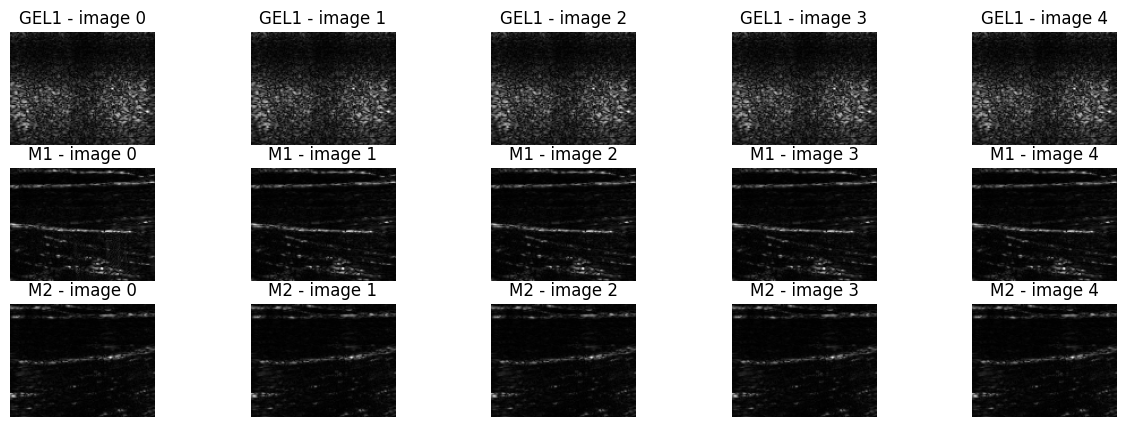

In [207]:
# Plot the data
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(3, 5, figsize=(15, 5))
for i in range(5):
    axs[0, i].imshow(np.abs(GEL1[:, :, i*10]), cmap='gray')
    axs[1, i].imshow(np.abs(M1[:, :, i*10]), cmap='gray')
    axs[2, i].imshow(np.abs(M2[:, :, i*10]), cmap='gray')
    # turn off the axis
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
    # set title
    axs[0, i].set_title(f'GEL1 - image {i}')
    axs[1, i].set_title(f'M1 - image {i}')
    axs[2, i].set_title(f'M2 - image {i}')
plt.show()

## Apply the time of flight (TOF) algorithm

### GEL 1 data

In [208]:
# compute displacements
displacements = np.abs(GEL1[:,:,:-1] - GEL1[:,:,1:])
c_displacements = GEL1[:,:,:-1] - GEL1[:,:,1:]
print("displacements of shape", displacements.shape)    

displacements of shape (100, 128, 59)


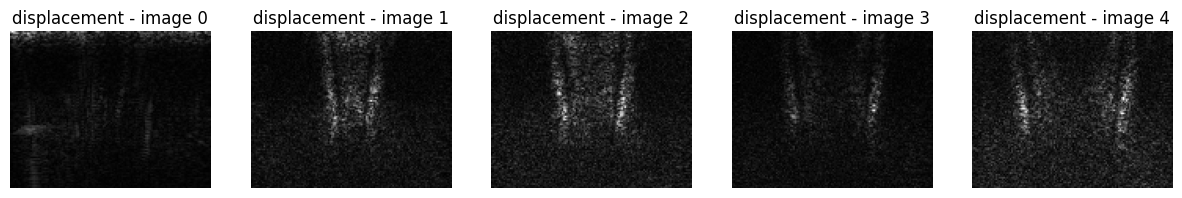

In [209]:
# Plot the displacements
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.abs(displacements[:, :, i*3]), cmap='gray')
    # turn off the axis
    axs[i].axis('off')
    # set title
    axs[i].set_title(f'displacement - image {i}')

In [210]:
def biased_cc(x_ref, x, dt, frames):
    T = frames.shape[2]
    
    Ux_ref = frames[x_ref[0], x_ref[1], 0:T]
    Ux_ref = np.tile(Ux_ref[np.newaxis,:], reps = (x.shape[0],1))

    Time = [ i+dt - T if i+dt >= T else i+dt for i in range(T)]
    Ux = frames[x[:,0],x[:,1], 0:T]
    Ux = Ux[:,Time]

    res = np.sum( Ux_ref * Ux.conj(), axis= 1)
    return (res/T)

In [211]:
# Test the biased_cc function
np.random.seed(0) 
x_ref = np.array([0,0])
x = np.array([[0,0],[0,1],[1,0],[1,1]])
frames = np.random.rand(3,2,5)
print("frames= \n",frames)
T = frames.shape[2]-1
dt = 1

Ux_ref = frames[x_ref[0], x_ref[1], 0:T]
Ux_ref = np.tile(Ux_ref[np.newaxis,:], reps = (x.shape[0],1))

Time = [ i-dt + T if i-dt < 0 else i-dt for i in range(T)]
time2 = np.mod(np.arange(T) - dt, T).astype(int) 
print("Time =\n", time2)
print("Time =\n", Time)
Ux = frames[x[:,0],x[:,1], 0:T]
Ux = Ux[:,time2]

# check shapes 
print(Ux)


frames= 
 [[[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
  [0.64589411 0.43758721 0.891773   0.96366276 0.38344152]]

 [[0.79172504 0.52889492 0.56804456 0.92559664 0.07103606]
  [0.0871293  0.0202184  0.83261985 0.77815675 0.87001215]]

 [[0.97861834 0.79915856 0.46147936 0.78052918 0.11827443]
  [0.63992102 0.14335329 0.94466892 0.52184832 0.41466194]]]
Time =
 [3 0 1 2]
Time =
 [3, 0, 1, 2]
[[0.54488318 0.5488135  0.71518937 0.60276338]
 [0.96366276 0.64589411 0.43758721 0.891773  ]
 [0.92559664 0.79172504 0.52889492 0.56804456]
 [0.77815675 0.0871293  0.0202184  0.83261985]]


In [212]:
# create coordinate array 
X, Y = np.meshgrid(np.arange(displacements.shape[0]), np.arange(displacements.shape[1]))
# flatten the matrices
X = X.flatten()
Y = Y.flatten()
# concatenate the coordinates
x = np.stack((X, Y), axis=1)

In [213]:
def biased_cc_map(x_ref, x, dt, frames):
    cc_displacement_map = np.zeros((frames.shape[0], frames.shape[1], frames.shape[2]+1))
    for tau in range(cc_displacement_map.shape[2]):
        cc = biased_cc(x_ref, x, tau, frames)
        r = np.reshape(cc, frames.shape[:2], order='F')
        cc_displacement_map[:,:,tau] = r

    return (cc_displacement_map)

In [214]:
print(x_ref)

[0 0]


In [215]:
maps = biased_cc_map(x_ref, x, 1, displacements)
T_hat = np.argmax(maps, axis=2)

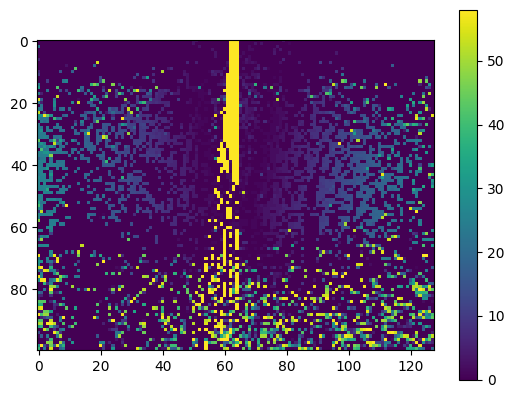

In [216]:
# Plot the time of flight
plt.imshow(T_hat)
plt.colorbar()
plt.show()

In [217]:
def cisaillement(T, i, j, dt, t_max):
    T_dt = T + dt
    ii = np.where(T == T_dt[i,j])

    if (T[i,j] == t_max):
        return -1
    
    else : 
        x_chap = tuple(zip(*ii))
        # print("x = ", (i, j), ", et les x_chap = ", x_chap)
        # print(" normes = ", np.array([(chap[0] - i)**2 + (chap[1] - j)**2 for chap in x_chap]))
        norm = (np.array([(chap[0] - i)**2 + (chap[1] - j)**2 for chap in x_chap]))
        if (np.array_equal(norm, np.array([]))) :
            return -1
        else :
            return 1000*min(norm)

def cisaillement_mat(T, dt, t_max):
    X, Y = np.meshgrid(np.arange(T.shape[0]), np.arange(T.shape[1]))
    # flatten the matrices
    X = X.flatten()
    Y = Y.flatten()
    # concatenate the coordinates
    x = np.stack((X, Y), axis=1)
    cis_mat = np.zeros(np.shape(T))
    for i in x:
       cis_mat[i[0], i[1]] = cisaillement(T, i[0], i[1], 1, t_max)
    return cis_mat

In [218]:
cis_mat = cisaillement_mat(T_hat, 1, 59)

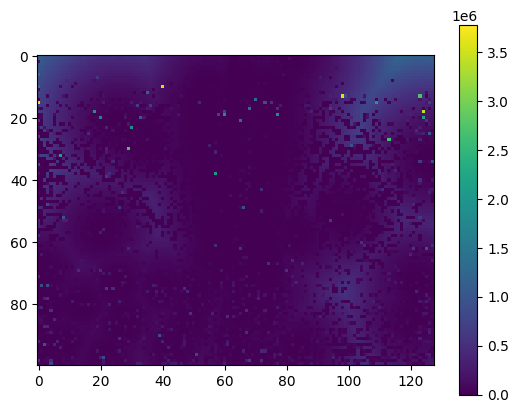

In [222]:
plt.imshow(cis_mat)
plt.colorbar()
plt.show()

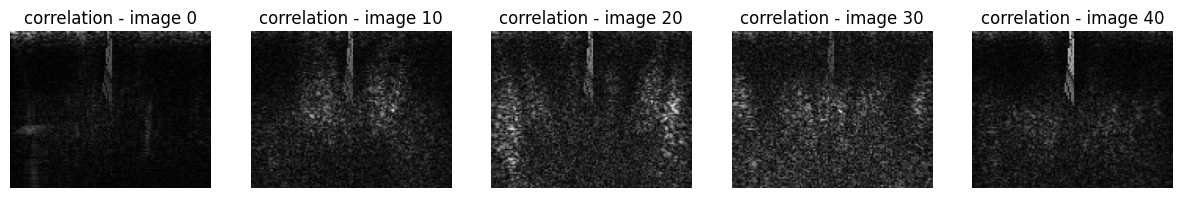

In [220]:
# Plot the correlation each 10 steps
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    #x_ref = np.array([0, 0])
    x_ref = (np.array(displacements.shape[:2])/2).astype(int)
    cc = biased_cc(x_ref, x, i*10, c_displacements)
    r = np.reshape(cc, c_displacements.shape[:2], order='F')
    axs[i].imshow(np.abs(r), cmap='gray')
    # turn off the axis
    axs[i].axis('off')
    # set title
    axs[i].set_title(f'correlation - image {i*10}')

# TESTS

In [221]:

displacement = []
for i in range(cross_M1.shape[0]-1):
    displacement.append(np.abs(cross_M1[i+1])-np.abs(cross_M1[i]))

# Plot the displacement
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axs[i].imshow(np.abs(displacement[i*10]))
    # turn off the axis
    axs[i].axis('off')
    # set title
    axs[i].set_title(f'Displacement - image {i}')

NameError: name 'cross_M1' is not defined

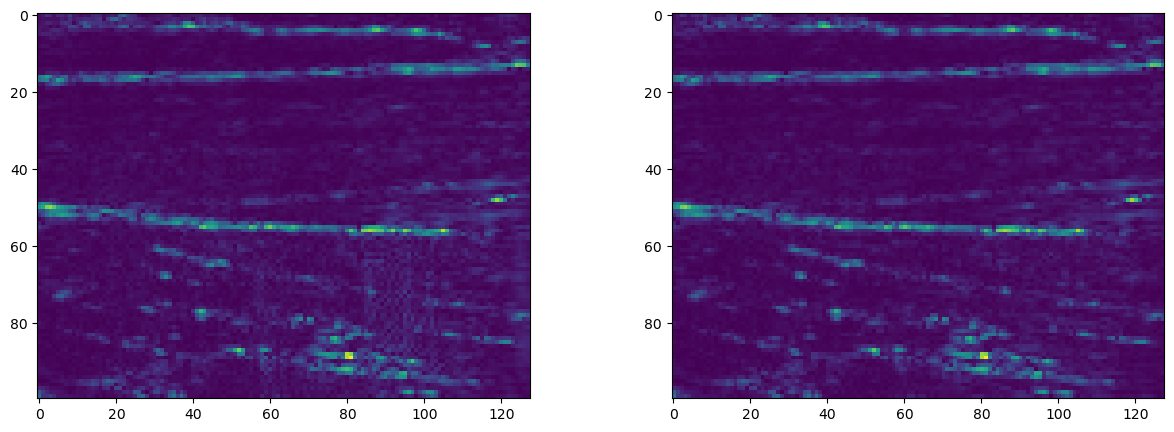

In [ ]:
# Take two M1 images
M1_t1 = M1[:, :, 0]
M1_t2 = M1[:, :, 10]
_, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(np.abs(M1_t1))
ax[1].imshow(np.abs(M1_t2))

In [ ]:
# Extract patches from an image and put them in a matrix
def patch_image(image, window_size, distinct_patches=True):
    patches = []
    n_x, n_y = image.shape
    window_step = window_size if distinct_patches else 1

    for i in range(0, n_x - window_size, window_step):
        Line_patches = []
        for j in range(0, n_y - window_size , window_step):
            Line_patches.append(image[i:i + window_size, j:j + window_size])
        patches.append(Line_patches)
    
    return np.array(patches)        


In [ ]:
# Patch M1_t1
window_size = 30
patches_M1_t1 = patch_image(M1_t1, window_size, distinct_patches=True)
xp, yp , _, _ = patches_M1_t1.shape
print("patches_M1_t1 of shape", patches_M1_t1.shape)   

patches_M1_t1 of shape (3, 4, 30, 30)


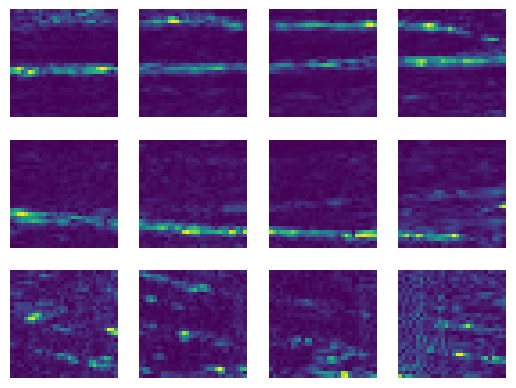

In [ ]:
# Plot patches of M1_t1
fig, axs = plt.subplots(xp, yp)
for i in range(xp):
    for j in range(yp):
        axs[i, j].imshow(np.abs(patches_M1_t1[i, j,:,:]))
        axs[i, j].axis('off')   

In [ ]:
def displacement(patch1, patch2):
    cross_corr = signal.correlate(patch1, patch2, mode="same")
    
    # # Compute the center of the patch   
    # center = np.array(np.unravel_index(np.argmax(auto_corr), auto_corr.shape))
    
    # # Compute the displacement
    # new_center = np.array(np.unravel_index(np.argmax(cross_corr), cross_corr.shape))
    dsp = np.angle(cross_corr)

    return dsp

In [ ]:
patches_M1_t2 = patch_image(M1_t2, window_size, distinct_patches=True)
patches_M1_t1 = patch_image(M1_t1, window_size, distinct_patches=True)

In [ ]:
# Compute overall displacement between frames
def frame_displacement(frame1, frame2):
    if (frame1.shape != frame2.shape):
        raise ValueError("The two frames must have the same shape")
    
    nx, ny, _, _ = frame1.shape
    dsp= []
    
    for i in range(nx):
        Line_dsp = []
        for j in range(ny):
            Line_dsp.append(displacement(frame1[i,j,:,:], frame2[i,j,:,:]))
        dsp.append(Line_dsp)
    return np.array(dsp)

NameError: name 'signal' is not defined

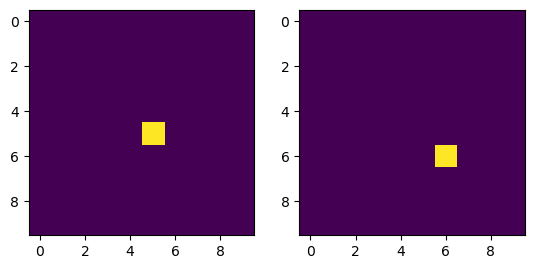

In [ ]:
T1 = np.zeros((10,10)); T1[5,5] = 1
T2 = np.zeros((10,10)); T2[6,6] = 1

T1_patch = patch_image(T1, 3)
T2_patch = patch_image(T2, 3)
_, ax = plt.subplots(1,2)

ax[0].imshow(T1)
ax[1].imshow(T2)

# Compute the displacement between patches
dsp = frame_displacement(T1_patch, T2_patch)
plt.figure()

In [ ]:
# compute the displacement between M1_t1 and M1_t2
M1_t1 , M1_t2 = np.abs(GEL1[:,:,0]), np.abs(M2[:,:,59])
d = frame_displacement(patches_M1_t1, patches_M1_t2)
d.shape
print(d)

[[[[ 1.8136792   1.7023171   1.5614856  ... -1.9268583  -1.8926955
    -1.6465976 ]
   [ 1.5110643   1.7799692   1.941542   ...  1.7477671   2.0236993
     2.389552  ]
   [-2.9563086  -2.3060884  -2.0495162  ... -1.5218978  -1.05615
    -0.63287354]
   ...
   [-2.3324952  -2.1910233  -2.1782942  ... -2.505045   -2.6311803
    -2.5326593 ]
   [ 0.38032097  0.6313057   1.0539474  ...  1.0905135   2.1018531
     2.325407  ]
   [-2.7378862  -2.3913426  -2.0198822  ... -2.2039905  -1.9180201
    -1.7759424 ]]

  [[ 2.1757226   1.6934907   1.1215074  ... -2.8864558  -3.025996
    -2.8825567 ]
   [-3.031253    2.7634811   2.3675635  ...  0.12350818 -0.2190153
    -0.292039  ]
   [-0.5510874  -0.8259477  -1.5291214  ... -2.3089626  -1.9655622
    -1.307735  ]
   ...
   [-1.1793948  -1.2177072  -1.240732   ...  1.9163972  -1.847546
    -1.7161559 ]
   [ 1.2262104   1.4124624   1.9918107  ...  2.0771334   1.1742796
     0.6249249 ]
   [-0.20510872  0.16607998  0.193248   ... -2.2213914  -2.41206